# Bond Fluctuation Model for a single chain 

In [1]:
%pylab notebook
import bfm_full as bfm
import time
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
help(bfm)

Help on module bfm_full:

NAME
    bfm_full - bfm simulation module

CLASSES
    builtins.object
        BFMSimulator
        excludedVolumeLattice
        monomer
        validBonds
    
    class BFMSimulator(builtins.object)
     |  BFMSimulator(box_, periodicity_)
     |  
     |  class providing utilities for 3D BFM simulations:
     |  monomer container, bondset, move and apply function
     |  
     |  Methods defined here:
     |  
     |  __init__(self, box_, periodicity_)
     |      setting up simulation box:
     |      box = [boxX, boxY, boxZ] (python list of int),
     |      periodicity = [pX, pY, pZ] (python list of bools), True = is periodic, False = wall
     |      bondset (instance of class validBonds)
     |      ... and setup:
     |      empty molecules as empty list,
     |      empty lattice (boxX*boxY*boxZ) with 0 as initial value (np.array),
     |      list of moves (python list)
     |  
     |  addMonomer(self, coords, attributes)
     |      add new monom

## Single chain with excluded volume 

In [3]:
''' Aufgabe 1: Lineare Kette erstellen, Ree, Rg und Ree-Autocorrelationsfunktion berechnen '''

# lineare Kette, Rg, Re, ...
def setupLinearChain(N,box):
    '''
    create single linear chain of length N in a cubic box of size box
    Input: linear chain lenght N ( int ), box size in one dimension ( int )
    Return: instance of BFMSimulator
    '''
    chainSim = bfm.BFMSimulator( [box,box,box], [True, True, True] )
    steps = [(2,0,0),(0,2,0),(0,0,2)]
    attribute = {"fixed": False}

    for n in range(N):
        if (n > 0):
            step = steps[np.random.randint(len(steps))]
            coords = chainSim.molecules[-1].coords + step
            chainSim.addMonomer(coords,attribute)
            chainSim.connectMonomers(len(chainSim.molecules)-2,len(chainSim.molecules)-1)
        else:
            chainSim.addMonomer(np.array([0,0,0]),attribute)
    
    # sanity check before return
    chainSim.checkConfig()
            
    return chainSim

def separateMolecules(molecules):
    '''
    Find single molecules of successive linear chains
    Input: instance of molecules (list of monomers)
    Return: List of separated molecules (list of lists of monomers)
    '''
    singleMolecule = []
    separatedMolecules = []
    for m in molecules:
        if (m.idx + 1) in m.bonds:
            singleMolecule.append(m)
        else:
            singleMolecule.append(m)
            separatedMolecules.append(singleMolecule)
            singleMolecule = []
    
    return separatedMolecules

def calcRee(bfmSimulator):
    ''' 
    Sort all monomers to single molecules and calculate Ree vector for each of them
    Input: instance of BFMSimulator
    Return: List of np.arrays of Ree vectors, one for each (linear) molecule
    '''
    sepMol = separateMolecules(bfmSimulator.molecules)
            
    Ree = []
    for mol in sepMol:
        Ree.append(mol[-1].coords - mol[0].coords)
    return Ree

def calcRg2(bfmSimulator):
    ''' 
    Sort all monomers to single molecules and calculate Rg componentes in x,y,z for each of them
    Input: instance of BFMSimulator
    Return: List of np.arrays of Rg vectors, one for each (linear) molecule
    '''
    sepMol = separateMolecules(bfmSimulator.molecules)
            
    Rg2All = []
    for mol in sepMol:
        # calculate center of mass
        centerOfMass = np.zeros((3))
        for mono in mol:
            centerOfMass += mono.coords
        centerOfMass /= len(mol)
        
        # get mean squared distances to center of mass
        Rg2 = np.zeros((3))
        for mono in mol:
            diff = mono.coords - centerOfMass
            Rg2 += (diff*diff)
        Rg2 /= len(mol)
        Rg2All.append(Rg2)
        
    return Rg2All
def calcPairCor(bfmSimulator, binsize=1.):
    '''
    Calculates the pair correlation function of the whole system.
    Input: instance of BFMSimulator
    Return: Two np.arrays with first the rdf and the corresponding bins.
    '''
    mol=bfmSimulator.molecules
    # calc all distances between monomers
    # bond length in the bfm is aroun 2.68 for an excluded volume chain and 
    # 2.714 for a ideal chain -> factor of 3 
    rdf = np.zeros(( int(len(mol)*3/binSize+1) ))
    bins= np.linspace(0,int(len(mol)*3), rdf.size )
    for mono1 in mol:
        for mono2 in mol[mono1.idx:]:
            diff = mono1.coords - mono2.coords
            rdf[int(np.linalg.norm(diff)/binsize) ]+=1
    rdf =rdf*2./len(mol)**2.
    return rdf, bins
def powerLaw(x,a,b):
    return a*x**b

In [4]:
# setup linear chain
N = 32            
boxXYZ = 64
chainSimulator = setupLinearChain(N,boxXYZ)

<IPython.core.display.Javascript object>


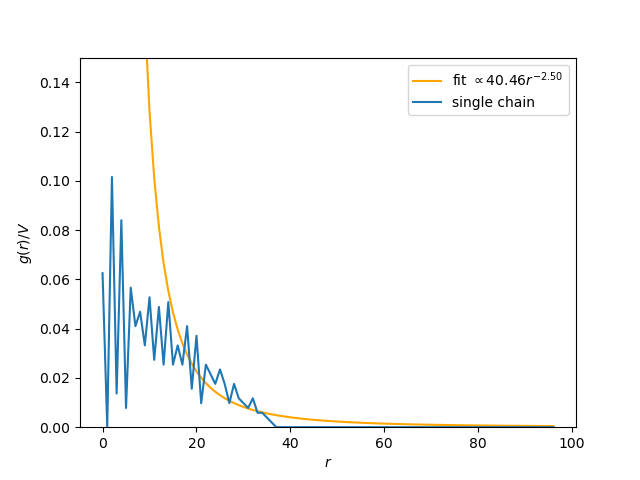

<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b


In [17]:
# test the rdf calculation
figure()
binSize=1.
RDF, BIN = calcPairCor(chainSimulator)
x=[ x>15 for x in BIN]
fit_params, covar = curve_fit( powerLaw, BIN[x], RDF[x] )
xlabel(r'$r$')
ylabel(r'$g(r)/V$')
ylim(0,0.15)
plot(BIN,powerLaw(BIN, *fit_params), label="fit $\propto {0:.2f}r^{{{1:.2f}}}$".format(fit_params[0], fit_params[1]), c = "orange")
plot(BIN,RDF, label='single chain')
legend(loc='best')

<IPython.core.display.Javascript object>


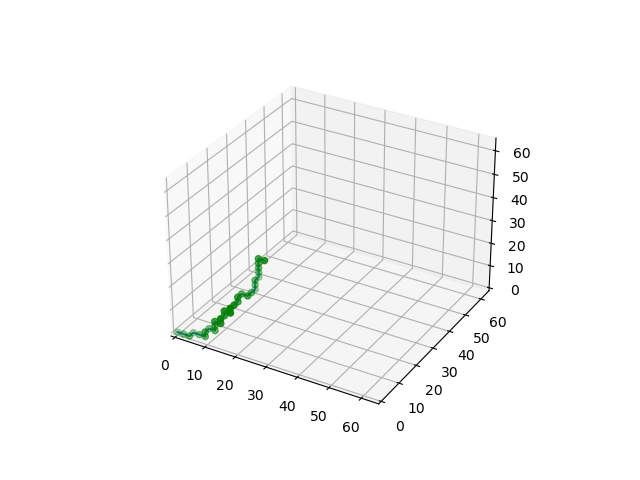

[array([18, 18, 26])]
[[4.63512405 6.37591905 8.04261113]]


In [18]:
# proof Ree, Rg, config
chainSimulator.plotConfig()
print(calcRee(chainSimulator))
print(np.sqrt(np.array(calcRg2(chainSimulator))))

In [7]:
# autocorrelation function
def sampleReDt(N,box,time):
    ''' function to get one sample of the autocorrelation of the end to end vector of a single BFM polymer chains'''
    # setup chain
    myChain = setupLinearChain(N,box)
    # short equilibration
    myChain.performMCS(10000)
    
    # initial result container
    firstRe = calcRee(myChain)[0]
    ReDt = [np.dot(firstRe,firstRe)]
    Re2 = [np.dot(firstRe,firstRe)]
    
    # run the simulations
    for i in range(time-1):
        myChain.performMCS(1)
        currentRe = calcRee(myChain)[0]
        Re2.append(np.dot(currentRe,currentRe))
        ReDt.append(np.dot(firstRe,currentRe))
        
    # average the Re2
    reMean = sum(Re2)/len(Re2)
    # return the results
    return reMean, np.array(ReDt)

In [8]:
s_time = 5000
n_sample = 10
N = 32
boxXYZ = 64

meanReDt = np.zeros(s_time)
reMean = 0.0
start=time.process_time()
for n in range(n_sample):
    reC, redtC = sampleReDt(N, boxXYZ, s_time)
    # print(reC, redtC.size)
    reMean += reC
    meanReDt += redtC
    print(n+1, reMean/(n+1), meanReDt/(n+1))

reMean /= n_sample
meanReDt /= n_sample
print(reMean, meanReDt[:4])
print("Simulation time {0:.2f}s ".format( time.process_time()-start ))

applied moves / attempted moves:
87100 / 320000 = 0.2721875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
a

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
ap

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves /

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied move

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
ap

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied m

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempte

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied m

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied mov

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves /

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied m

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
app

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / att

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applie

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
11 / 32 = 0.34375
applied mo

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.406

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves /

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied mo

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attem

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied move

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
appl

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
appl

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applie

7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
1 663.8788 [321. 321. 321. ... 373. 359. 359.]
applied moves / attempted moves:
86921 / 320000 = 0.271628125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied mo

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
appl

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied m

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
appl

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
appli

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
appl

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied mov

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / a

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied move

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied mo

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied move

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
a

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied move

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
app

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
appli

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / atte

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied mo

applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves /

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
3 / 32 = 0.09375
applied move

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
appl

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
ap

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applie

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / 

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied move

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:


applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied mo

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
ap

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied mo

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied move

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves /

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
appl

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied mov

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied mo

applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempte

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied mo

applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied mov

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
14 / 32 = 0.4375
applied 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125


applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves 

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
appli

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / at

applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
app

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / a

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
4 / 32 = 0.125
applied 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted m

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
a

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / at

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
appli

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
app

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attemp

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / att

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / at

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applie

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves /

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applie

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied mov

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / a

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
appli

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied m

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied m

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied move

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied 

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
appl

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied m

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875


applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / a

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
appli

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied move

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied move

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
16 / 32 = 0.5
applied 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
appli

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied mo

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applie

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applie

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / atte

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied mo

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
appl

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied mo

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
11 / 32 = 0.34375
appli

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied mov

applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves 

applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves /

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied mov

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applie

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied move

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied mov

11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied move

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied mov

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves 

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied mov

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / at

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
19 / 32 = 0.59375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves /

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempt

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied move

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applie

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
appli

applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied mov

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
app

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
app

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
appli

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
a

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied mov

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied m

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied mov

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applie

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves /

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied 

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied m

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applie

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied mo

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / 

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applie

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
appl

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attem

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves /

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / atte

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied mov

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applie

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
19 / 32 = 0.59375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
appli

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied move

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied mo

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
ap

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
app

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves /

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied m

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied mov

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied m

applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
appl

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied m

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied mo

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves /

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
ap

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves /

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied m

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied mov

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves /

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / a

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875


applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
10 / 32 = 0.3125
appli

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
appl

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
appli

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied 

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / a

applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves 

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied mov

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied m

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
appl

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / atte

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
1 / 32 = 0.03125
applied moves / attempted moves:
3 / 32 = 0.09375
applied mov

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / at

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied 

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied 

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
ap

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied move

applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied mov

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / 

applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves /

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / atte

applied moves / attempted moves:
18 / 32 = 0.5625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied move

applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied 

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves 

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
12 / 32 = 0.375
applied move

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves

applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied m

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied mo

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applie

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied 

applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves /

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applie

applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
2 / 32 = 0.0625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / 

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied mov

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
15 / 32 = 0.46875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves 

applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
16 / 32 = 0.5
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / att

applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
a

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied 

applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attemp

applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied mo

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves 

applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
3 / 32 = 0.09375
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
7 / 32 = 0.21875
applied moves / attempted moves:
4 / 32 = 0.125
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
5 / 32 = 0.15625
applie

applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
17 / 32 = 0.53125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
8 / 32 = 0.25
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
9 / 32 = 0.28125
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
5 / 32 = 0.15625
applied moves / attempted moves:
11 / 32 = 0.34375
applied moves / attempted moves:
14 / 32 = 0.4375
applied moves / attempted moves:
12 / 32 = 0.375
applied moves / attempted moves:
13 / 32 = 0.40625
applied moves / attempted moves:
10 / 32 = 0.3125
applied moves / attempted moves:
6 / 32 = 0.1875
applied moves / attempted moves:
9 / 32 = 0.28125


<IPython.core.display.Javascript object>


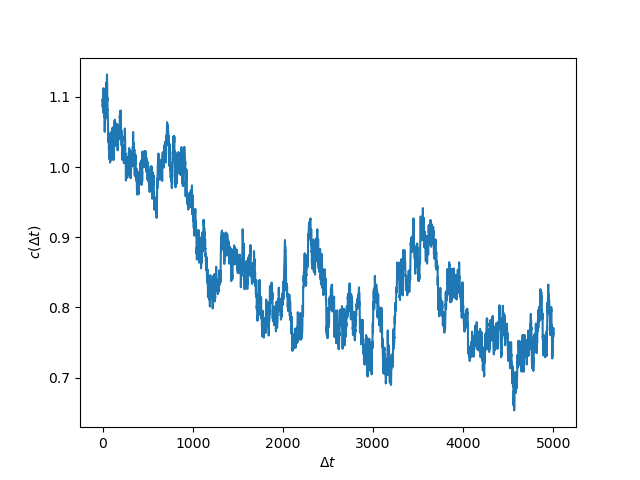

In [19]:
figure()
# plot(np.linspace(0,s_time,s_time),meanReDt/meanReDt[0])
plot(np.linspace(0,s_time,s_time),meanReDt/reMean)
xlabel(r"$\Delta t$")
ylabel(r"$c(\Delta t)$")
show()

In [10]:
''' Aufgabe 2: Lineare Kette im Confinement (Spalt/Schlitz) '''

def setupLinChainInConfinement(N,box, periodicity):
    '''
    create single linear chain of length N in a cubic box of size box
    Input: linear chain lenght N ( int ), box size in one dimension ( int )
    Return: instance of BFMSimulator
    '''
    boxX, boxY, boxZ = box
    pX, pY, pZ = periodicity
    chainSim = bfm.BFMSimulator( [boxX, boxY, boxZ], [pX, pY, pZ] )
    
    if np.all(np.array([pX, pY, pZ])):
        steps = [(2,0,0),(0,2,0),(0,0,2)]
        start = [0,0,0]
    elif ( ( not pZ ) and ( not pY ) ):
        steps = [(2,0,0)]
        start = [0,int(boxY/2),int(boxZ/2)]
    elif ( (not pZ) and (pY) ):
        steps = [(2,0,0),(0,2,0)]
        start = [0,0,int(boxZ/2)]
    else:
        print("Warning: box periodicity {} not supported!".format(periodicity))
        
    attribute = {"fixed": False}

    for n in range(N):
        if (n > 0):
            step = steps[random.randint(len(steps))]
            coords = chainSim.molecules[-1].coords + step
            chainSim.addMonomer(coords,attribute)
            chainSim.connectMonomers(len(chainSim.molecules)-2,len(chainSim.molecules)-1)
        else:
            chainSim.addMonomer(np.array(start),attribute)
    
    # sanity check before return
    chainSim.checkConfig()
            
    return chainSim

## Polymers in a slit 

<IPython.core.display.Javascript object>


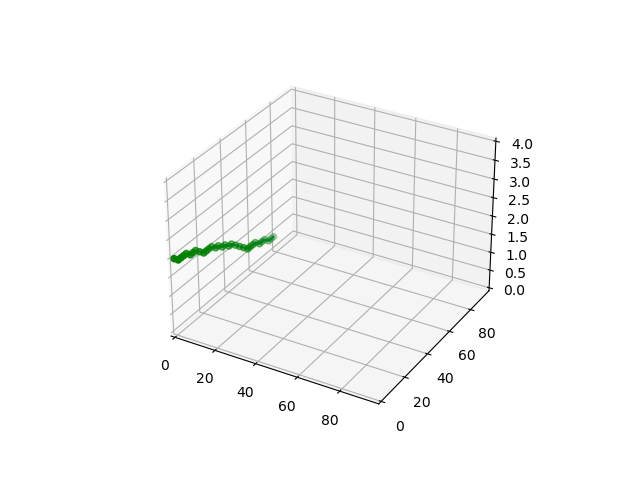

applied moves / attempted moves:
946 / 3200 = 0.295625


<IPython.core.display.Javascript object>


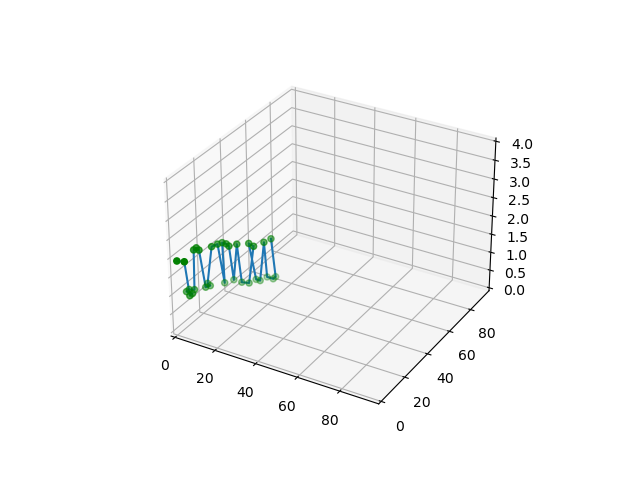

In [20]:
N = 32
box = [96, 96, 4]
period = [True, True, False]
confSim = setupLinChainInConfinement(N, box, period)
confSim.plotConfig()
confSim.performMCS(100)
confSim.plotConfig()

In [30]:
# Check Ree/ Rg for different slit sizes:
period = [True,True, False]
N = 32
boxXY = 64
boxZ = [64, 32, 16, 8, 4]

n_samples = 50
meanRee = []
meanRg2 = []
meanRDF = []
meanBin = []
binSize = 1. 
start=time.process_time()
for z in boxZ:
    # setup config
    confChain = setupLinChainInConfinement(N,[boxXY, boxXY, z], period)
    # run equilibration ( 10k steps)
    confChain.performMCS(10000)
    # run long simulation to make measurements
    currentRee = np.zeros((3))
    currentRg2 = np.zeros((3))
    currentRDF = np.zeros((int(N*3/binSize+1))) 
    currentBin = np.zeros((int(N*3/binSize+1))) 
    for n in range(n_samples):
        confChain.performMCS(1000)
        currentRee += np.array(calcRee(confChain)[0])
        currentRg2 += np.array(calcRg2(confChain)[0])
        tmpRDF, tmpBin =np.array(calcPairCor(confChain))
        currentRDF += tmpRDF
        currentBin += tmpBin
    print(z,": Ree = ", currentRee/n_samples,", Rg2 = ", currentRg2/n_samples)
    meanRee.append(currentRee/n_samples)
    meanRg2.append(currentRg2/n_samples)
    meanRDF.append(currentRDF/n_samples)
    print(currentRDF/n_samples)
    meanBin.append(currentBin/n_samples)
    
print(boxZ, meanRee, meanRg2)
data = np.vstack((boxZ,np.array(meanRee)[:,0],np.array(meanRee)[:,1],np.array(meanRee)[:,2],np.array(meanRg2)[:,0],np.array(meanRg2)[:,2],np.array(meanRg2)[:,2]))
np.savetxt("slit_data_n32.dat",data)
print("Simulation time {0:.2f}s ".format( time.process_time()-start ))

applied moves / attempted moves:
87763 / 320000 = 0.274259375
applied moves / attempted moves:
8858 / 32000 = 0.2768125
applied moves / attempted moves:
8948 / 32000 = 0.279625
applied moves / attempted moves:
8787 / 32000 = 0.27459375
applied moves / attempted moves:
8728 / 32000 = 0.27275
applied moves / attempted moves:
8572 / 32000 = 0.267875
applied moves / attempted moves:
8595 / 32000 = 0.26859375
applied moves / attempted moves:
8840 / 32000 = 0.27625
applied moves / attempted moves:
8972 / 32000 = 0.280375
applied moves / attempted moves:
8994 / 32000 = 0.2810625
applied moves / attempted moves:
8606 / 32000 = 0.2689375
applied moves / attempted moves:
8622 / 32000 = 0.2694375
applied moves / attempted moves:
8631 / 32000 = 0.26971875
applied moves / attempted moves:
8476 / 32000 = 0.264875
applied moves / attempted moves:
8534 / 32000 = 0.2666875
applied moves / attempted moves:
8725 / 32000 = 0.27265625
applied moves / attempted moves:
8418 / 32000 = 0.2630625
applied moves 

applied moves / attempted moves:
87041 / 320000 = 0.272003125
applied moves / attempted moves:
8691 / 32000 = 0.27159375
applied moves / attempted moves:
8854 / 32000 = 0.2766875
applied moves / attempted moves:
8548 / 32000 = 0.267125
applied moves / attempted moves:
8659 / 32000 = 0.27059375
applied moves / attempted moves:
8846 / 32000 = 0.2764375
applied moves / attempted moves:
8634 / 32000 = 0.2698125
applied moves / attempted moves:
8850 / 32000 = 0.2765625
applied moves / attempted moves:
8532 / 32000 = 0.266625
applied moves / attempted moves:
8953 / 32000 = 0.27978125
applied moves / attempted moves:
8851 / 32000 = 0.27659375
applied moves / attempted moves:
8601 / 32000 = 0.26878125
applied moves / attempted moves:
8603 / 32000 = 0.26884375
applied moves / attempted moves:
8823 / 32000 = 0.27571875
applied moves / attempted moves:
8529 / 32000 = 0.26653125
applied moves / attempted moves:
8473 / 32000 = 0.26478125
applied moves / attempted moves:
8736 / 32000 = 0.273
applied

applied moves / attempted moves:
87512 / 320000 = 0.273475
applied moves / attempted moves:
8947 / 32000 = 0.27959375
applied moves / attempted moves:
8703 / 32000 = 0.27196875
applied moves / attempted moves:
8969 / 32000 = 0.28028125
applied moves / attempted moves:
8493 / 32000 = 0.26540625
applied moves / attempted moves:
8865 / 32000 = 0.27703125
applied moves / attempted moves:
8686 / 32000 = 0.2714375
applied moves / attempted moves:
8934 / 32000 = 0.2791875
applied moves / attempted moves:
8694 / 32000 = 0.2716875
applied moves / attempted moves:
8565 / 32000 = 0.26765625
applied moves / attempted moves:
9009 / 32000 = 0.28153125
applied moves / attempted moves:
9125 / 32000 = 0.28515625
applied moves / attempted moves:
8770 / 32000 = 0.2740625
applied moves / attempted moves:
8639 / 32000 = 0.26996875
applied moves / attempted moves:
8911 / 32000 = 0.27846875
applied moves / attempted moves:
8602 / 32000 = 0.2688125
applied moves / attempted moves:
8676 / 32000 = 0.271125
appl

{0: 'k', 1: 'b', 2: 'y', 3: 'g', 4: 'r'}


<IPython.core.display.Javascript object>


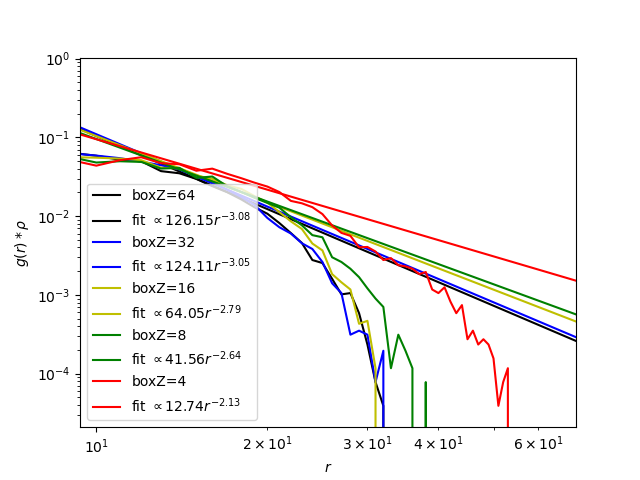

<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value en

In [31]:
cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }
print(cmap)
figure()
params=[]
for i in range(5):
    x=[ y > 10 and y < 40  for y in meanBin[i]-binSize ]
    fit_params, covar = curve_fit( powerLaw, meanBin[i][x], meanRDF[i][x] )
    params.append(fit_params)
    cn = cmap[i]
    plot(meanBin[i]-binSize,meanRDF[i], color=cn, label = "boxZ="+str(boxZ[i]))
    plot(meanBin[i]-binSize,powerLaw(meanBin[i]-binSize, *params[i]),color=cn, label="fit $\propto {0:.2f}r^{{{1:.2f}}}$".format(params[i][0], params[i][1]))

# plot(meanBin[1]-binSize,32+(meanBin[1]-binSize)*0,label = "$N=32$" )
legend(loc="best")
yscale('log')
xscale('log')
ylim(0,20000)
xlabel(r"$r$")
ylabel(r"$g(r)*\rho$")
show()

<IPython.core.display.Javascript object>


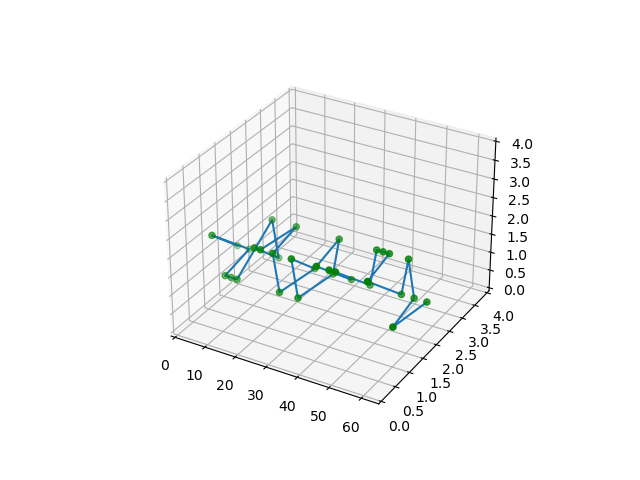

<IPython.core.display.Javascript object>


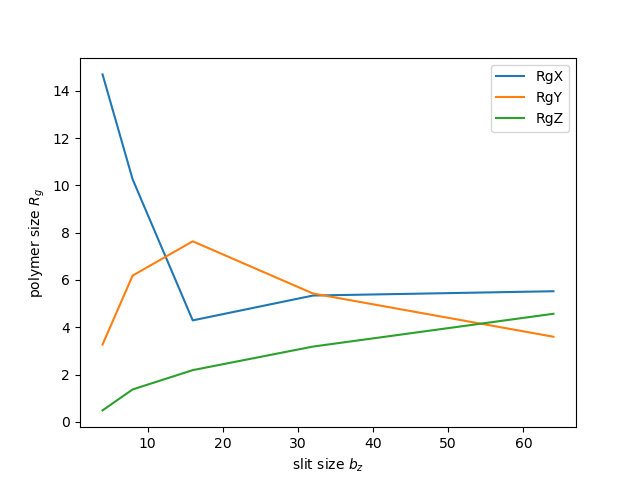

In [23]:
confChain.plotConfig()

figure()
plot(boxZ,np.sqrt(np.array(meanRg2)[:,0]), label = "RgX")
plot(boxZ,np.sqrt(np.array(meanRg2)[:,1]), label = "RgY")
plot(boxZ,np.sqrt(np.array(meanRg2)[:,2]), label = "RgZ")
legend(loc="best")
xlabel(r"slit size $b_{z}$")
ylabel(r"polymer size $R_{g}$")
show()

## Polymers in a pore 

In [32]:
# Check Ree/ Rg for different pore sizes:
period = [True, False, False]
N = 32
boxX = 64
boxYZ = [64, 32, 16, 8, 4]

n_samples = 50
mean2Ree = []
mean2Rg2 = []
mean2RDF = []
mean2Bin = []
binSize = 1.
start=time.process_time()
for yz in boxYZ:
    # setup config
    confChain = setupLinChainInConfinement(N,[boxX, yz, yz], period)
    # run equilibration ( 10k steps)
    confChain.performMCS(10000)
    # run long simulation to make measurements
    currentRee = np.zeros((3))
    currentRg2 = np.zeros((3))
    currentRDF = np.zeros((int(N*3/binSize+1))) 
    currentBin = np.zeros((int(N*3/binSize+1))) 
    for n in range(n_samples):
        confChain.performMCS(1000)
        currentRee += np.array(calcRee(confChain)[0])
        currentRg2 += np.array(calcRg2(confChain)[0])
        tmpRDF, tmpBin =np.array(calcPairCor(confChain))
        currentRDF += tmpRDF
        currentBin += tmpBin
    print(yz,": Ree = ", currentRee/n_samples,", Rg2 = ", currentRg2/n_samples)
    mean2Ree.append(currentRee/n_samples)
    mean2Rg2.append(currentRg2/n_samples)
    mean2RDF.append(currentRDF/n_samples)
    mean2Bin.append(currentBin/n_samples)
    
print(boxYZ, mean2Ree, mean2Rg2)
data = np.vstack((boxYZ,np.array(mean2Ree)[:,0],np.array(mean2Ree)[:,1],np.array(mean2Ree)[:,2],np.array(mean2Rg2)[:,0],np.array(mean2Rg2)[:,2],np.array(mean2Rg2)[:,2]))
np.savetxt("pore_data_n32.dat",data)
print("Simulation time {0:.2f}s ".format( time.process_time()-start ))

applied moves / attempted moves:
86370 / 320000 = 0.26990625
applied moves / attempted moves:
8690 / 32000 = 0.2715625
applied moves / attempted moves:
8683 / 32000 = 0.27134375
applied moves / attempted moves:
8362 / 32000 = 0.2613125
applied moves / attempted moves:
8875 / 32000 = 0.27734375
applied moves / attempted moves:
8430 / 32000 = 0.2634375
applied moves / attempted moves:
8729 / 32000 = 0.27278125
applied moves / attempted moves:
8646 / 32000 = 0.2701875
applied moves / attempted moves:
8632 / 32000 = 0.26975
applied moves / attempted moves:
8667 / 32000 = 0.27084375
applied moves / attempted moves:
8557 / 32000 = 0.26740625
applied moves / attempted moves:
8628 / 32000 = 0.269625
applied moves / attempted moves:
8649 / 32000 = 0.27028125
applied moves / attempted moves:
8653 / 32000 = 0.27040625
applied moves / attempted moves:
8509 / 32000 = 0.26590625
applied moves / attempted moves:
8430 / 32000 = 0.2634375
applied moves / attempted moves:
8683 / 32000 = 0.27134375
appli

applied moves / attempted moves:
8965 / 32000 = 0.28015625
applied moves / attempted moves:
8788 / 32000 = 0.274625
applied moves / attempted moves:
8584 / 32000 = 0.26825
applied moves / attempted moves:
8552 / 32000 = 0.26725
applied moves / attempted moves:
8869 / 32000 = 0.27715625
applied moves / attempted moves:
8805 / 32000 = 0.27515625
applied moves / attempted moves:
8414 / 32000 = 0.2629375
applied moves / attempted moves:
8361 / 32000 = 0.26128125
applied moves / attempted moves:
8567 / 32000 = 0.26771875
applied moves / attempted moves:
9063 / 32000 = 0.28321875
applied moves / attempted moves:
8767 / 32000 = 0.27396875
applied moves / attempted moves:
8565 / 32000 = 0.26765625
applied moves / attempted moves:
8899 / 32000 = 0.27809375
applied moves / attempted moves:
8507 / 32000 = 0.26584375
16 : Ree =  [15.38  1.82 -1.52] , Rg2 =  [43.31396484  8.82269531  7.74546875]
applied moves / attempted moves:
87638 / 320000 = 0.27386875
applied moves / attempted moves:
8785 / 320

{0: 'k', 1: 'b', 2: 'y', 3: 'g', 4: 'r'}


<IPython.core.display.Javascript object>


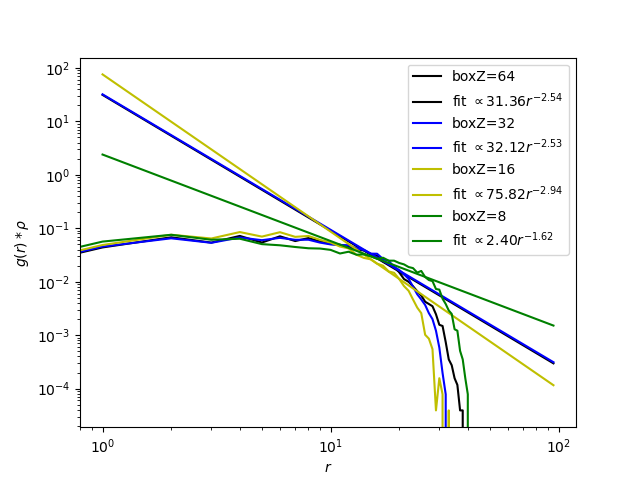

<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: divide by zero encountered in power
  return a*x**b
<ipython-input-3-2501a5399646>:103: RuntimeWarning: invalid value encountered in power
  return a*x**b


In [48]:
cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }
print(cmap)
figure()
params2=[]
for i in range(5):
    x=[ y > 10 and y < 40   for y in mean2Bin[i]-binSize ]
    fit_params, covar = curve_fit( powerLaw, mean2Bin[i][x], mean2RDF[i][x] )
    params2.append(fit_params)
    cn = cmap[i]
    if(i <4):
        plot(mean2Bin[i]-binSize,mean2RDF[i], color=cn, label = "boxZ="+str(boxZ[i]))
        plot(mean2Bin[i]-binSize,powerLaw(mean2Bin[i]-binSize, *params2[i]),color=cn, label="fit $\propto {0:.2f}r^{{{1:.2f}}}$".format(params2[i][0], params2[i][1]))

# plot(mean2Bin[1]-binSize,32+(mean2Bin[1]-binSize)*0,label = "$N=32$" )
legend(loc="best")
yscale('log')
xscale('log')

xlabel(r"$r$")
ylabel(r"$g(r)*\rho$")
show()

<IPython.core.display.Javascript object>


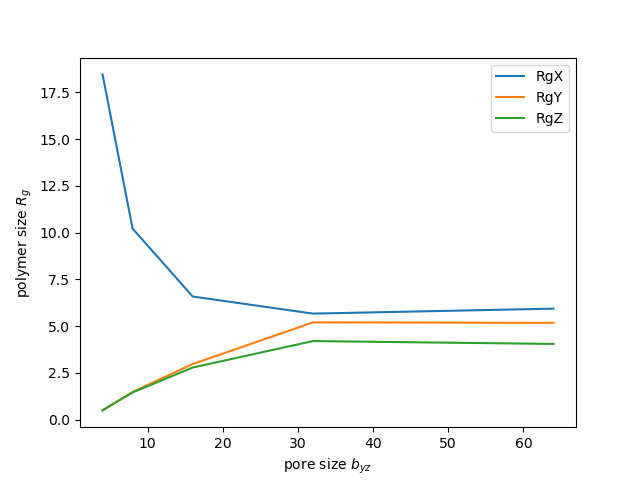

In [36]:
figure()
plot(boxYZ,np.sqrt(np.array(mean2Rg2)[:,0]), label = "RgX")
plot(boxYZ,np.sqrt(np.array(mean2Rg2)[:,1]), label = "RgY")
plot(boxYZ,np.sqrt(np.array(mean2Rg2)[:,2]), label = "RgZ")
legend(loc="best")
xlabel(r"pore size $b_{yz}$")
ylabel(r"polymer size $R_{g}$")
show()

Das Scaling fuer beide Situationen ist nicht aussagekraeftig, da die Kurven zu schnell nach unten abknicken und sich so nicht ein regime ausbildet, wo man ein Skaling ablesen kann. Um das zu korrigieren, braeuchte man laengere Ketten...Es ist also sinnvollere den Gyrationsradius zu betrachten und Schluesse daraus zu ziehen in dieser Situation.